In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

import datetime
from ngram import *
from baselines import *
from stats_utils import get_beta_dist, bayesian_ci
from error_analysis import *
import os
import fnmatch
import numpy as np
import time
import multiprocessing as mp
import re 

In [3]:
import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from data_generation.diff_utils import clean_and_filter

# Run Models

#### Load Models

In [7]:
m_agg = joblib.load( '../../models/aggression_regression_ngram.pkl')
m_rec = joblib.load( '../../models/recipient_ngram.pkl')

#### Load annotationed diffs

In [8]:
d_b, d_r = load_cf_data()
d_annotations = tidy_labels(d_r)
d_annotated = d_annotations.drop_duplicates(subset=['rev_id'])

d_annotated['recipient'] = plurality(d_annotations['recipient'].dropna())
d_annotated['recipient_score'] = average(d_annotations['recipient'].dropna())

d_annotated['aggression'] = average(d_annotations['aggression_score'].dropna())
d_annotated['rev_timestamp'] = d_annotated['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%dT%H:%M:%SZ"))
d_annotated['pred_aggression_score'] =  m_agg.predict(d_annotated['clean_diff'])
d_annotated['pred_recipient_score'] =  get_scores(m_rec, d_annotated['clean_diff'])

#### Load samples and apply models

We take various diffs datasets from hive, apply the clean and filter function and the score the clean diffs using the models.

In [9]:
def pred_helper(df):
    df = clean_and_filter(df)
    if len(df) == 0:
        return None
    df['rev_timestamp'] = df['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%dT%H:%M:%SZ"))
    df['pred_aggression_score'] =  m_agg.predict(df['clean_diff'])
    df['pred_recipient_score'] =  get_scores(m_rec, df['clean_diff'])
    return df
    
def prep_in_parallel(path, k = 8):
    names = ['rev_comment', 'diff', 'insert_only', 'rev_id', 'page_id', 'page_title', 'rev_timestamp', 'user_id', 'user_text']
    df = pd.read_csv(path, sep = '\t', quoting = 3, encoding = 'utf-8', header = None, usecols = range(9))
    df.columns = names
    df['key'] = np.random.randint(0, high=5*k, size=df.shape[0])
    dfs = [e[1] for e in df.groupby('key')]
    t1 = time.time()
    p = mp.Pool(k)
    dfs = p.map(pred_helper, dfs)
    p.close()
    p.join()
    t2 = time.time()
    print(t2-t1)
    return pd.concat(dfs)

def prep_data(path, m_rec, m_agg):
    files = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    dfs = [prep_in_parallel(p, k = 6) for p in files]
    cols = ['rev_id', 'clean_diff', 'rev_timestamp', 'pred_aggression_score', 'pred_recipient_score', 'page_title', 'user_text','user_id']
    df = pd.concat(dfs)
    return df [cols]

In [10]:
%%capture
df_no_admin_sample  = prep_data('../../data/user_talk_diff_no_admin_sample',  m_rec, m_agg)
#df_no_bot_sample  = prep_data('../../data/user_talk_diff_no_bot_sample', m_rec, m_agg)
df_no_admin_2015  = prep_data('../../data/user_talk_diff_no_admin/year=2015',  m_rec, m_agg)
#df_no_bot_2015    = prep_data('../../data/user_talk_diff_no_bot/year=2015',  m_rec, m_agg)
df_blocked_user  = prep_data('../../data/blocked_user_talk_diff_no_admin', m_rec, m_agg)

d_annotated.to_csv('d_annotated.tsv', sep = '\t')
df_no_admin_sample.to_csv('df_no_admin_sample.tsv', sep = '\t')
#df_no_bot_sample.to_csv('df_no_bot_sample.tsv', sep = '\t')
df_no_admin_2015.to_csv('df_no_admin_2015.tsv', sep = '\t')
#df_no_bot_2015.to_csv('df_no_bot_2015.tsv', sep = '\t')
df_blocked_user.to_csv('df_blocked_user.tsv', sep = '\t')

# Load Predictions

#### Load model predictions

In [4]:
d_annotated = pd.read_csv('d_annotated.tsv', sep = '\t')
df_no_admin_sample = pd.read_csv('df_no_admin_sample.tsv', sep = '\t')
#df_no_bot_sample = pd.read_csv('df_no_bot_sample.tsv', sep = '\t')
df_no_admin_2015 = pd.read_csv('df_no_admin_2015.tsv', sep = '\t')
#df_no_bot_2015 = pd.read_csv('df_no_bot_2015.tsv', sep = '\t')
df_blocked_user = pd.read_csv('df_blocked_user.tsv', sep = '\t')

#### Load block events

In [5]:
df_events = pd.read_csv('../../data/v4/block_events.tsv', sep = '\t')
df_events.columns = [c.split('.')[1] for c in df_events.columns]
df_events['timestamp'] = df_events['timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%dT%H:%M:%SZ"))

#### Augment with some easy features

In [6]:
for df in [df_blocked_user, df_no_admin_sample, df_no_admin_2015, d_annotated]:
    df['author_anon'] = df['user_id'].isnull()
    df['recipient_anon'] = df['page_title'].apply(lambda x: re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$",str(x)) is not None)
    df['rev_timestamp'] = df['rev_timestamp'].apply(lambda x: datetime.datetime.strptime (x, "%Y-%m-%d %H:%M:%S"))
    df['year'] = df['rev_timestamp'].apply(lambda x: x.year)
    df['month'] = df['rev_timestamp'].apply(lambda x: x.month)
    df['hour'] = df['rev_timestamp'].apply(lambda x: x.hour)
    df['pred_aggression_score'] = -1 * df['pred_aggression_score']
    df['pred_recipient'] = (df['pred_recipient_score'] > 0.5).astype(int)
    df['own_page'] = df['user_text'] == df['page_title']
    
d_annotated['aggression'] = d_annotated['aggression'] * -1

# Model Checking

### Q: What do comments in different score intervals look like?

In [332]:
def check_range(d, col, min, max, n = 10, ):
    df = d.query('%s >= %f and %s <= %f' % (col, min, col, max))
    for i, r in df[:10].iterrows():
        print(r[col])
        print(r.clean_diff)
        print('\n')  
    

In [334]:
#check_range(df_no_admin_sample, 'pred_recipient_score', 0.4, 0.5)

### Q: How does the distribution over aggression scores compare across annotators vs models and different data sets

This is mainly a sanity check that the aggression model is working new data

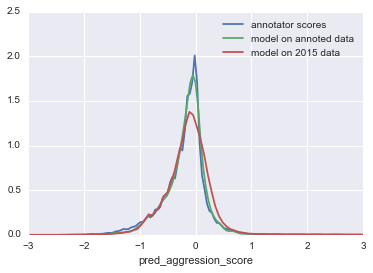

In [337]:
# annotations
sns.distplot(d_annotated['aggression'].dropna()*-1, hist=False, label = 'annotator scores')

# model on annotated data
sns.distplot(d_annotated['pred_aggression_score'].dropna(), hist=False, label = 'model on annoted data')

#model no admin sample
sns.distplot(df_no_admin_sample['pred_aggression_score'].dropna(), hist=False, label = 'model on 2015 data')

plt.xlim(-3, 3)
plt.legend()

### Q: How does the distribution over attack probabilities compare across annotators vs models and different data sets

This is mainly a sanity check that the attack model is working new data

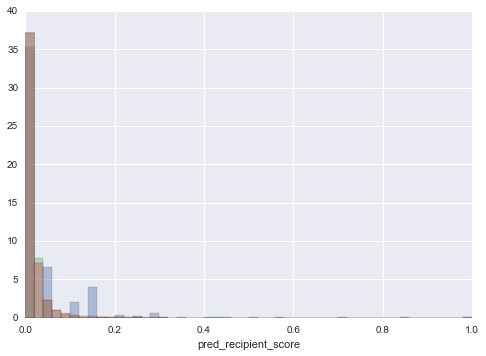

In [109]:
sns.distplot(d_annotated['recipient_score'].dropna(), kde =False, norm_hist = True)
sns.distplot(d_annotated['pred_recipient_score'].dropna(), kde =False, norm_hist = True)
sns.distplot(df_no_admin_sample['pred_recipient_score'].dropna(), kde =False, norm_hist = True)

# Quantifying Prevalence of Personal Attacks

### Q: What fraction of comments are personal attacks?

Methodology 1: Compute credible interval for probability that a comment was labeled as an attack by the majority of annotators.

In [9]:
# annotators:
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(d_annotated['recipient'].sum(), d_annotated.shape[0]), 95)

'Fraction of comments labeled as attacks: (0.006, 0.009)'

In [10]:
# model on annotator data Note: this is currently not kosher since the model was trained on this data
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % bayesian_ci(get_beta_dist(d_annotated['pred_recipient'].sum(), d_annotated.shape[0]), 95)

'Fraction of comments labeled as attacks: (0.005, 0.008)'

Methodology 2: Compute fraction of comments predicted to be attacks for different classification thresholds

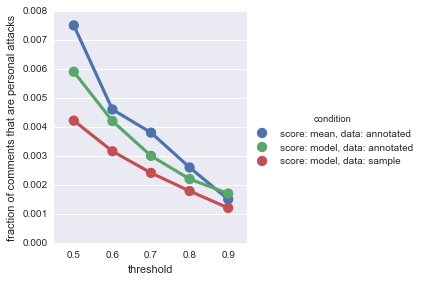

In [199]:
plt.figure()
# score = mean of annotations
d_aa = pd.concat([pd.DataFrame({'threshold': t, 'attack': d_annotated['recipient_score'] >= t }) for t in np.arange(0.5, 0.91, 0.1)], axis = 0)
d_aa['condition'] = 'score: mean, data: annotated'
#ax = sns.pointplot(x='threshold', y= 'attack', data=d_temp, ci = None, label = 'mean annotations on annotated data')

# score = model score on annotated data
d_ma = pd.concat([pd.DataFrame({'threshold': t, 'attack': d_annotated['pred_recipient_score'] >= t }) for t in np.arange(0.5, 0.91, 0.1)], axis = 0) 
d_ma['condition'] = 'score: model, data: annotated'
#ax = sns.pointplot(x='threshold', y= 'attack', data=d_temp, ci = None, label = 'model score on annotated data')

# score = model score on sample data
d_ms = pd.concat([pd.DataFrame({'threshold': t, 'attack': df_no_admin_sample['pred_recipient_score'] > t }) for t in np.arange(0.5, 0.91, 0.1)], axis = 0) 
d_ms['condition'] = 'score: model, data: sample' 
#ax = sns.pointplot(x='threshold', y= 'attack', data=d_temp, ci = None, label = 'model on sample data')

sns.factorplot(x="threshold", y="attack", hue="condition", data=pd.concat([d_aa, d_ma, d_ms]), ci = None)
plt.ylabel('fraction of comments that are personal attacks')

Methodology 3: Use model/annotator probabilities to build distribution over number of attacks and then take 95% interval. This relies on the model being well calibrated.  

In [201]:
def compute_ci(a, n = 1000):
    m = a.shape[0]
    v = a.values.reshape((m,1))
    fs = np.sum(np.random.rand(m, n) < v, axis = 0) / m
    print("Fraction of comments labeled as attacks: (%.4f, %.4f)" % ( np.percentile(fs, 2.5), np.percentile(fs, 97.5)))
    
    
# annotator probs
print('Scores: mean annotation, Data: annotated')
compute_ci(d_annotated['recipient_score'])

# model probs on annotator data
print('Scores: model, Data: annotated')
compute_ci(d_annotated['pred_recipient_score'])

# model on sample data
print('Scores: model, Data: sample')
compute_ci(df_no_admin_sample['pred_recipient_score'])

Scores: mean annotation, Data: annotated
Fraction of comments labeled as attacks: (0.0340, 0.0403)
Scores: model, Data: annotated
Fraction of comments labeled as attacks: (0.0200, 0.0253)
Scores: model, Data: sample
Fraction of comments labeled as attacks: (0.0232, 0.0241)


### Q: What fraction of users have made a personal attack?

Methodology: Take unsampled data. Compute fraction of people who authored one comment that was predicted to be a personal attack. TODO: applying a clasifier may bias the results here, since  prolific users who are benign may get a misclassified comment with high probability.

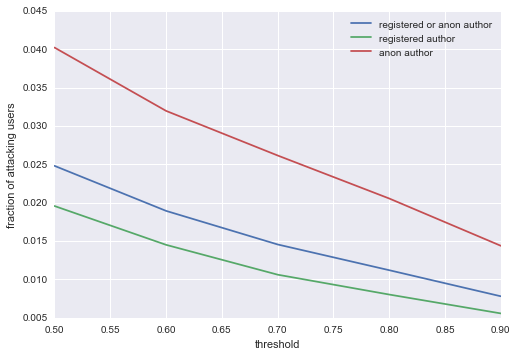

In [202]:
n_writing_users = len(df_no_admin_2015['user_text'].unique())
n_writing_anon_users = len(df_no_admin_2015.query('author_anon == True')['user_text'].unique())
n_writing_registered_users = n_writing_users - n_writing_anon_users

ts = np.arange(0.5, 0.91, 0.1)
fs = []
reg_fs = []
anon_fs = []

for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t]
    n_attacking_users = len(attacks['user_text'].unique())
    n_attacking_anon_users = len(attacks.query('author_anon == True')['user_text'].unique())
    n_attacking_registered_users = n_attacking_users - n_attacking_anon_users
    fs.append(((n_attacking_users/n_writing_users)))
    anon_fs.append(((n_attacking_anon_users/n_writing_anon_users)))
    reg_fs.append(((n_attacking_registered_users/n_writing_registered_users)))
plt.plot(ts, fs, label = 'registered or anon author')
plt.plot(ts, reg_fs, label = 'registered author')
plt.plot(ts, anon_fs, label = 'anon author')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('fraction of attacking users')

### Q: What fraction of attacking users have been blocked for harassment?

TODO: Also consider just registered users 

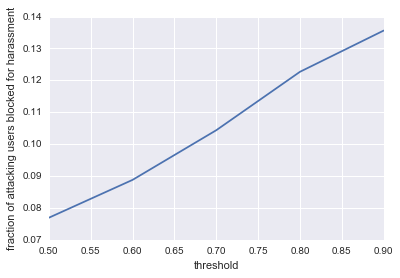

In [239]:
fs = []
blocked_users = set(df_events['user_text'].unique())
for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t]
    attacking_users = set(attacks['user_text'].unique())
    blocked_attacking_users = attacking_users.intersection(blocked_users)
    fs.append(len(blocked_attacking_users)/ len(attacking_users))
plt.plot(ts, fs)
plt.xlabel('threshold')
plt.ylabel('fraction of attacking users blocked for harassment')

### Q: What fraction of attacking comments come from users blocked for harassment?

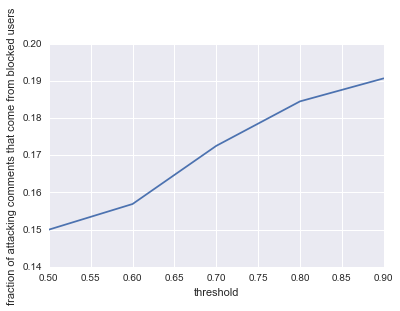

In [241]:
fs = []
for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t]
    n_attacking_comments = attacks.shape[0]
    n_attacking_comments_from_blocked_users = attacks.merge(df_blocked_user, how = 'inner', on = 'rev_id').shape[0]
    fs.append(n_attacking_comments_from_blocked_users/n_attacking_comments)
        
plt.plot(ts, fs)
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments that come from blocked users')

### Q: What fraction of attacking comments were followed by a block event?
Within one week

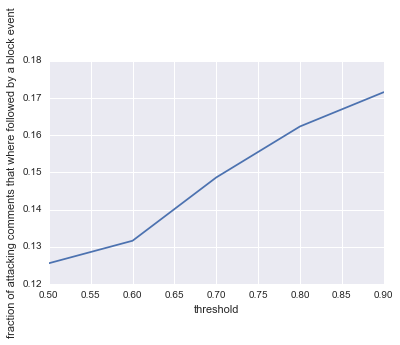

In [276]:
fs = []
for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t][['user_text', 'rev_id', 'rev_timestamp']]
    attacks = attacks.merge(df_events, how = 'left', on = 'user_text')
    attacks['blocked'] = (attacks['timestamp'] - attacks['rev_timestamp']) <  pd.Timedelta('7 days') 
    attacks.drop_duplicates(subset = 'rev_id', inplace = True)
    fs.append(attacks['blocked'].mean())
plt.plot(ts, fs)
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments that where followed by a block event')

### Q: How does the probablity of a user being blocked change with the number of attacking comments?

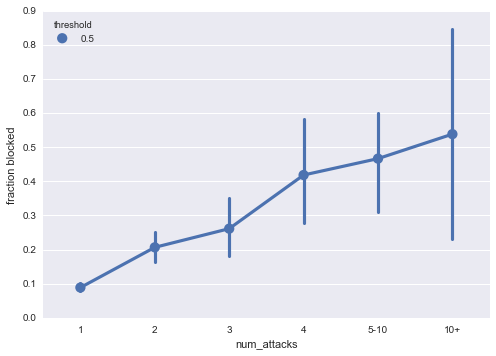

In [89]:
def remap(x):
    if x < 5:
        return str(x)
    if x < 10:
        return '5-10'
    else:
        return '10+'
dfs = []   
for t in [0.5, ]:
    blocked_users = df_events[['user_text']].drop_duplicates()
    blocked_users['blocked'] = 1
    blocked_users.index = blocked_users.user_text
    attacking_users = df_no_admin_2015.query('pred_recipient_score >= %f' % t).groupby('user_text', as_index = False)['pred_recipient'].sum()
    attacking_users.index = attacking_users.user_text
    attacking_users['blocked'] = blocked_users['blocked']
    attacking_users['blocked'] = attacking_users['blocked'].fillna(0)
    attacking_users['num_attacks'] = attacking_users['pred_recipient'].apply(remap)
    attacking_users['threshold'] = t
    dfs.append(attacking_users)
    
ax = sns.pointplot(x='num_attacks', y= 'blocked', data=pd.concat(dfs), hue = 'threshold', order = ('1', '2', '3', '4', '5-10', '10+'))
plt.ylabel('fraction blocked')

### Q: What fraction of users have been attacked?

Methodology: Take unsampled data. Compute fraction of people who recieved one comment that was predicted to be a personal attack. TODO: why have there been so many more attackers and victims? Compute ratio of attacks received by user and order user by that ratio.


Note: do not include comments made by the user on their own page.

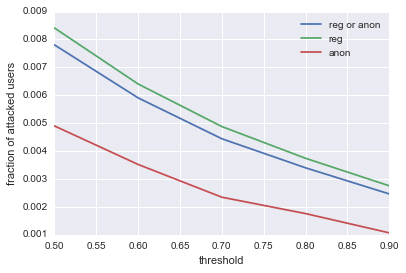

In [340]:
n_receiving_users = len(df_no_admin_2015['page_title'].unique())
n_receiving_anon_users = len(df_no_admin_2015.query('recipient_anon == True')['page_title'].unique())
n_receiving_registered_users = n_receiving_users - n_receiving_anon_users

ts = np.arange(0.5, 0.91, 0.1)
fs = []
reg_fs = []
anon_fs = []

for t in ts:
    attacks = df_no_admin_2015[df_no_admin_2015['pred_recipient_score'] >=t].query('not own_page')
    n_attacked_users = len(attacks['page_title'].unique())
    n_attacked_anon_users = len(attacks.query('recipient_anon == True')['page_title'].unique())
    n_attacked_registered_users = n_attacked_users - n_attacked_anon_users
    fs.append(((n_attacked_users/n_receiving_users)))
    anon_fs.append(((n_attacked_anon_users/n_receiving_anon_users)))
    reg_fs.append(((n_attacked_registered_users/n_receiving_registered_users)))
plt.plot(ts, fs, label = 'reg or anon')
plt.plot(ts, reg_fs, label = 'reg')
plt.plot(ts, anon_fs, label = 'anon')
plt.legend()
plt.xlabel('threshold')
plt.ylabel('fraction of attacked users')

In [ ]:
#model blocked user
sns.distplot(df_no_admin_sample['pred_aggression_score'].dropna())
plt.xlim(-3, 3)

### Q: How are aggression and personal attacks related? Is it just the attacks that are aggressive or are their other types if aggression?

Methodology: check pearson correlation between aggression and attack scores for sample or unsampled data.

In [147]:
d_temp = d_annotated.dropna(subset=['aggression', 'recipient_score'])
pearson(d_temp['aggression'],d_temp['recipient_score'])

-0.49449657698564492

In [148]:
d_temp = d_annotated.dropna(subset=['pred_aggression_score', 'pred_recipient_score'])
pearson(d_temp['pred_aggression_score'],d_temp['pred_recipient_score'])

0.50679885288799709

In [149]:
pearson(df_no_admin_sample['pred_aggression_score'],df_no_admin_sample['pred_recipient_score'])

0.50377788080715624

# Group Comparisons

Lets break down data into different groups and compare the mean aggression and attack scores

In [302]:
def mpg(df, score, cols):
    """
    return row with max score in each group of cols values
    """
    return df.sort(score, ascending=False).groupby(cols, as_index=False).first()

def compare_groups(df, x, mpu = False, order = None, hue = None, plot = True, table = True):
    
    if table:
        if hue:
            print(df.groupby([x, hue])['pred_aggression_score', 'pred_recipient_score'].mean())

        else:
            print(df.groupby([x])['pred_aggression_score', 'pred_recipient_score'].mean())
    
    
    if plot:
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize = (12,6))

        if mpu:
            cols = ['user_text', x]
            plt.figure()
            sns.pointplot(x=x, y= 'pred_aggression_score', data=mpg(df, 'pred_aggression_score', cols) , order = order, hue = hue, ax = ax1)
            plt.figure()
            sns.pointplot(x=x, y= 'pred_recipient_score', data=mpg(df, 'pred_recipient_score', cols) , order = order, hue = hue, ax = ax2)
        else:
            
            ax = sns.pointplot(x=x, y= 'pred_aggression_score', data=df, order = order, hue = hue, ax = ax1)
            plt.figure()
            ax = sns.pointplot(x=x, y= 'pred_recipient_score', data=df, order = order, hue = hue, ax = ax2)
            

### Q: How do comments made by registered and anonymous authors compare?

             pred_aggression_score  pred_recipient_score
author_anon                                             
False                    -0.159146              0.021017
True                      0.161384              0.080690


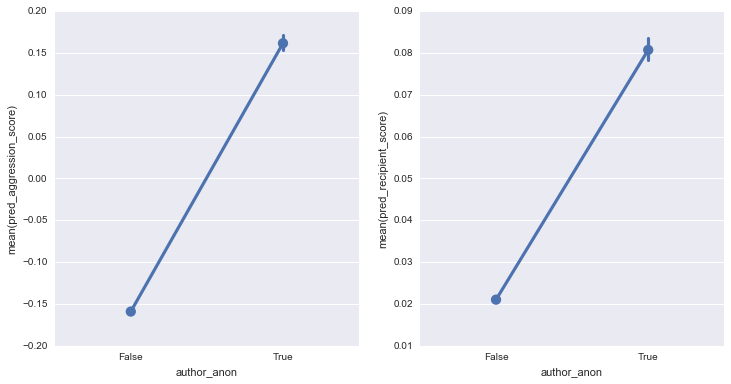

In [303]:
o = (False, True)
x = 'author_anon'
compare_groups(df_no_admin_sample, x, order = o)

In [119]:
#x = 'author_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do comments received by registered and anonymous authors compare?

                pred_aggression_score  pred_recipient_score
recipient_anon                                             
False                       -0.169383              0.022839
True                        -0.080746              0.017986


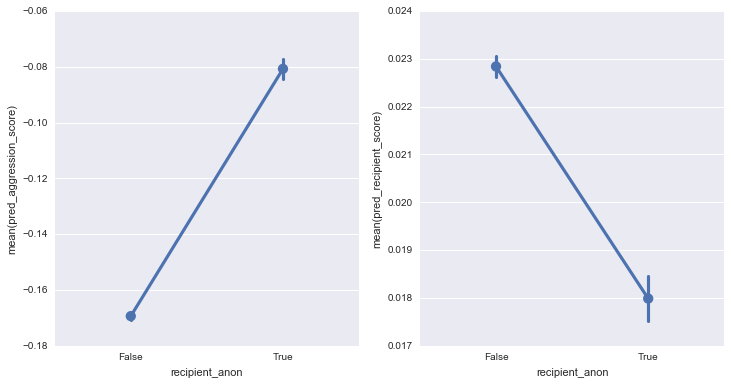

In [248]:
# don't count posts to own article
x = 'recipient_anon'
compare_groups(df_no_admin_sample.query('not own_page'), x, order = o)

In [136]:
#x = 'recipient_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do authors write differently on their own page than on other pages?

          pred_aggression_score  pred_recipient_score
own_page                                             
False                 -0.157191              0.022172
True                  -0.096649              0.029579


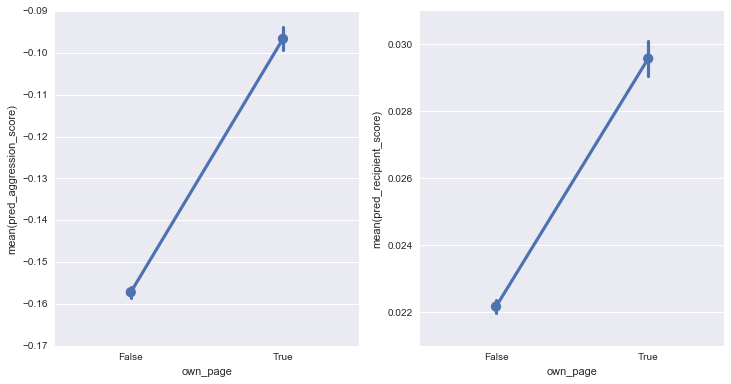

In [138]:
x = 'own_page'
o = (False, True)
compare_groups(df_no_admin_sample, x, order = o)

                      pred_aggression_score  pred_recipient_score
own_page author_anon                                             
False    False                    -0.169815              0.019864
         True                      0.127380              0.074188
True     False                    -0.117193              0.025550
         True                      0.266122              0.100719


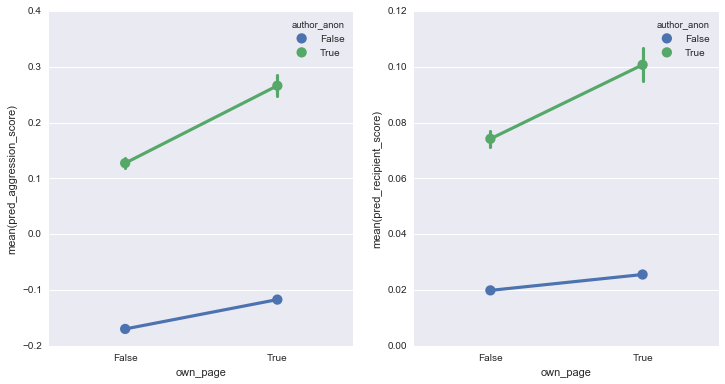

In [139]:
x = 'own_page'
compare_groups(df_no_admin_sample, x, order = o, hue = 'author_anon')

## Time

### Q: Has the amount of aggressiveness and attacks changed year over year?

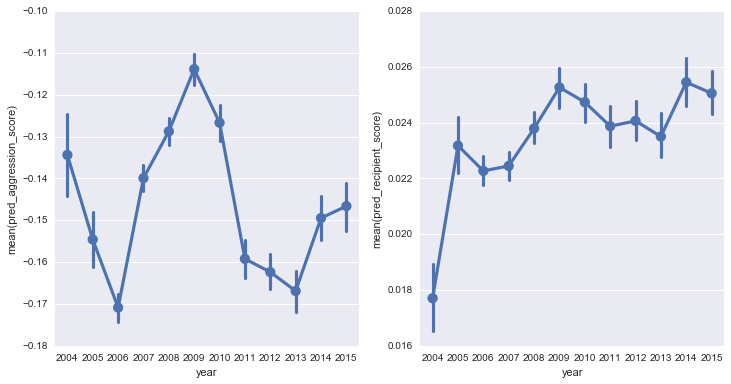

In [144]:
df_span = df_no_admin_sample.query('year > 2003 & year < 2016')
x = 'year'
o = range(2004, 2016)
compare_groups(df_span, x, order = o, table = False)

### Q: Is there a seasonal effect?

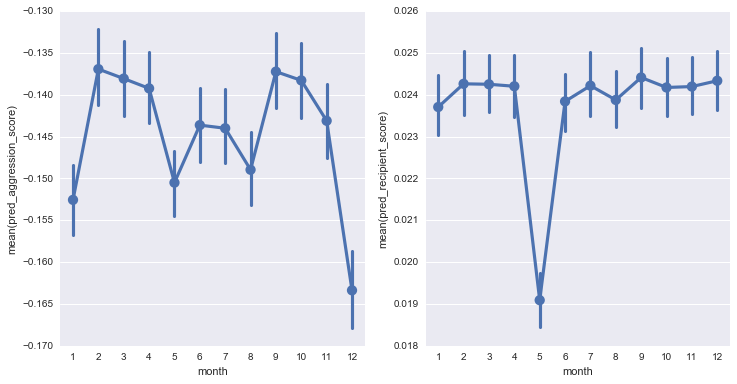

In [145]:
x = 'month'
o = range(1, 13)
compare_groups(df_no_admin_sample, x, order = o, table = False)

### Q: Is there an hour of day effect?

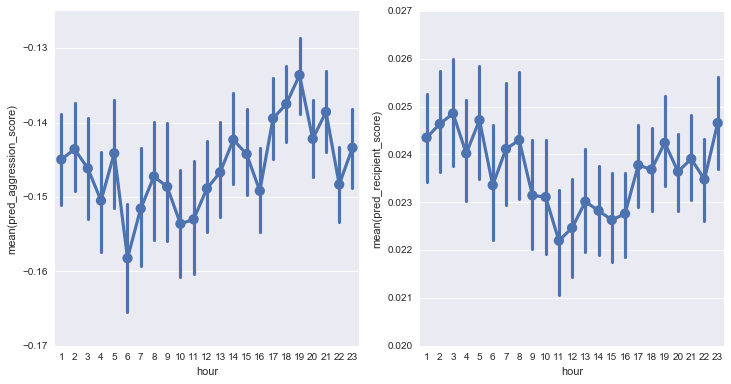

In [146]:
x = 'hour'
o  = range(1, 24)
compare_groups(df_no_admin_sample, x, order = o, table = False)

## Gender

In [150]:
from db_utils import query_analytics_store

In [257]:
## Annotate users by gender
query = """
SELECT
    user_id,
    user_name as user_text,
    up_value as gender
FROM
    enwiki.user_properties p,
    enwiki.user u
WHERE 
    p.up_user = u.user_id
    AND up_property = 'gender'
"""
d_gender = query_analytics_store(query, {})
d_gender.to_csv('genders.tsv', sep = '\t', index = False)

In [315]:
def remap_author_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['author_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
    
df_no_admin_gender = df_no_admin_2015.merge(d_gender, how = 'left', on = 'user_id', suffixes = ('', '_x'))
df_no_admin_gender['author_gender'] = df_no_admin_gender.apply(remap_author_gender, axis = 1)
del df_no_admin_gender['gender']
del df_no_admin_gender['user_text_x']

In [317]:
def remap_recipient_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['recipient_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
df_no_admin_gender = df_no_admin_gender.merge(d_gender, how = 'left', left_on = 'page_title', right_on = 'user_text', suffixes = ('', '_x'))
df_no_admin_gender['gender'] = df_no_admin_gender['gender'].fillna('unknown')
df_no_admin_gender['recipient_gender'] = df_no_admin_gender.apply(remap_recipient_gender, axis = 1)
del df_no_admin_gender['gender']
del df_no_admin_gender['user_text_x']
del df_no_admin_gender['user_id_x']

In [318]:
df_no_admin_gender.author_gender.value_counts()

unknown: registered    526238
male                   352870
unknown:anon            56624
female                  48662
Name: author_gender, dtype: int64

In [319]:
df_no_admin_gender.recipient_gender.value_counts()

unknown: registered    586002
male                   305094
unknown:anon            48434
female                  44864
Name: recipient_gender, dtype: int64

### Q: What is the effect of the author's gender?

                     pred_aggression_score  pred_recipient_score
author_gender                                                   
female                           -0.192264              0.021552
male                             -0.165550              0.019830
unknown: registered              -0.150523              0.025334
unknown:anon                      0.097533              0.062953


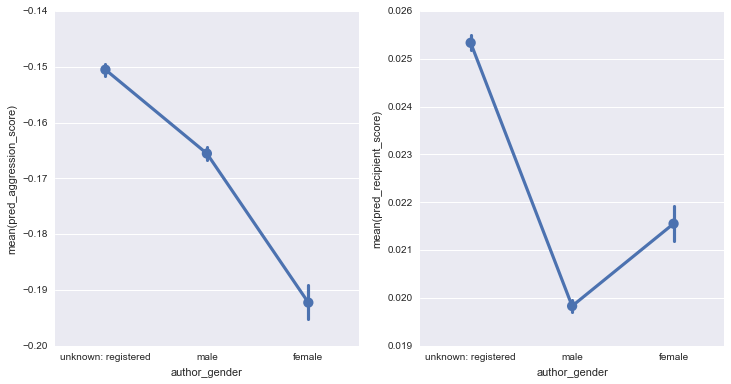

In [324]:
o = ('unknown: registered', 'male', 'female')
x = 'author_gender'
compare_groups(df_no_admin_gender, x, order = o)

### Q: What is the effect of the recipient's gender?

                     pred_aggression_score  pred_recipient_score
recipient_gender                                                
female                           -0.178579              0.024917
male                             -0.156561              0.026493
unknown: registered              -0.161115              0.023812
unknown:anon                     -0.069378              0.027764


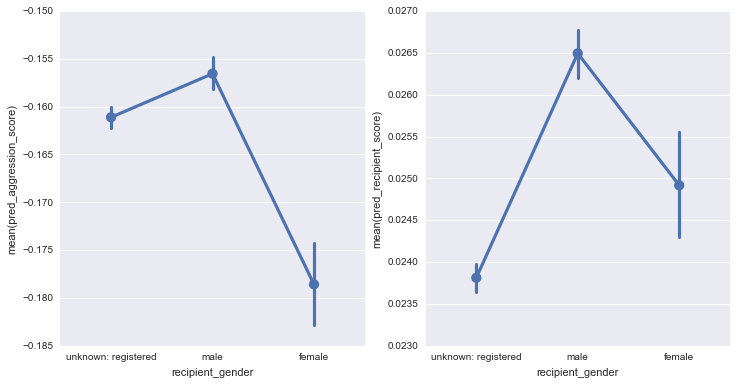

In [326]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query('not own_page'), x, order= o)

### Q: How does the effect change when you interact author and recipient gender?

                                         pred_aggression_score  \
recipient_gender    author_gender                                
female              female                           -0.215489   
                    male                             -0.182542   
                    unknown: registered              -0.194457   
male                female                           -0.206702   
                    male                             -0.183455   
                    unknown: registered              -0.169063   
unknown: registered female                           -0.199809   
                    male                             -0.159646   
                    unknown: registered              -0.182459   
unknown:anon        female                           -0.111910   
                    male                             -0.097705   
                    unknown: registered              -0.076615   

                                         pred_recipient_score  
recipient_g

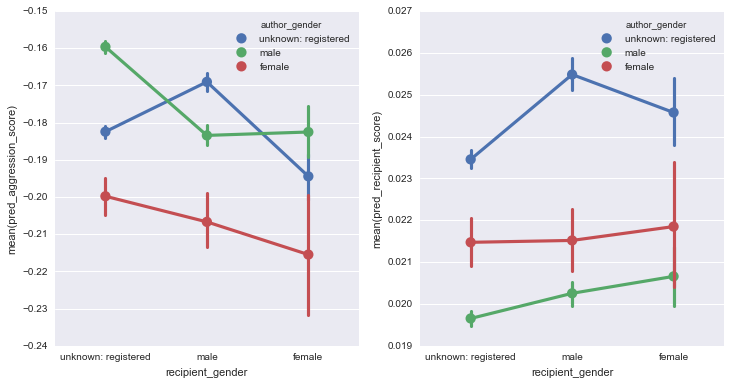

In [331]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query("not own_page and author_gender != 'unknown:anon'"), x, order = o, hue = 'author_gender')

### Q: Is tone reciprocal?

Methodology 1: is the average aggression score of what A says on B's page related to the average score of what B says on A's page?

In [7]:
d_tmp = df_no_admin_2015.query('not own_page and not author_anon and not recipient_anon')
pairs = d_tmp.groupby(['user_text', 'page_title'], as_index = False)[['pred_aggression_score']].mean()
pairs['key'] = 'From:' + pairs['user_text'] + ' to:' + pairs['page_title']
pairs['partner_key'] = 'From:' + pairs['page_title'] + ' to:' + pairs['user_text']
pairs = pairs.merge(pairs, left_on = 'partner_key', right_on = 'key', how = 'inner' )

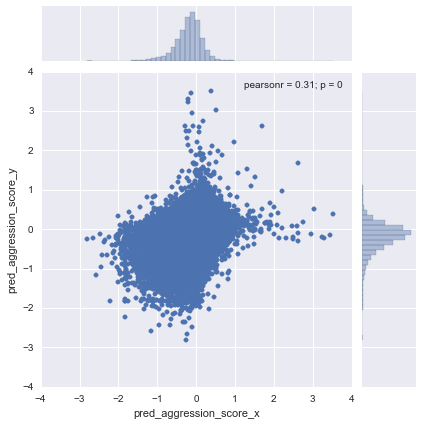

In [8]:
sns.jointplot(x = 'pred_aggression_score_x', y = 'pred_aggression_score_y', data = pairs)

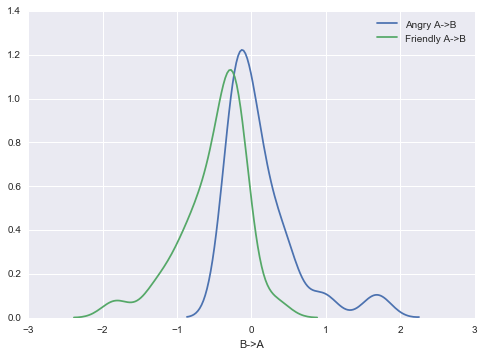

In [9]:
sns.distplot(pairs.query('pred_aggression_score_x > 2')['pred_aggression_score_y'], hist=False, label = 'Angry A->B')
sns.distplot(pairs.query('pred_aggression_score_x < -2')['pred_aggression_score_y'], hist=False, label = 'Friendly A->B')
plt.xlabel('B->A')

Methodology 2: is the aggression score of what A says on B's page related to the score of the next thing B says on A's page?

In [10]:
cols =  ['user_text', 'page_title', 'clean_diff', 'pred_aggression_score', 'rev_timestamp', 'rev_id']
ab = df_no_admin_2015.query('not own_page and not author_anon and not recipient_anon')[cols]
ba = ab.copy().rename(columns = {'user_text': 'page_title', 'page_title': 'user_text'})[cols]
d_temp = ab.merge(ba, on = ['user_text', 'page_title'], how = 'inner' )
d_temp['delta'] = d_temp['rev_timestamp_x'] - d_temp['rev_timestamp_y']
d_temp = d_temp[d_temp['delta'] > pd.Timedelta('0 days')]
d_temp = d_temp[d_temp['delta'] < pd.Timedelta('30 days')]
d_temp = d_temp.sort('delta', ascending=False).groupby('rev_id_x', as_index=False).first()

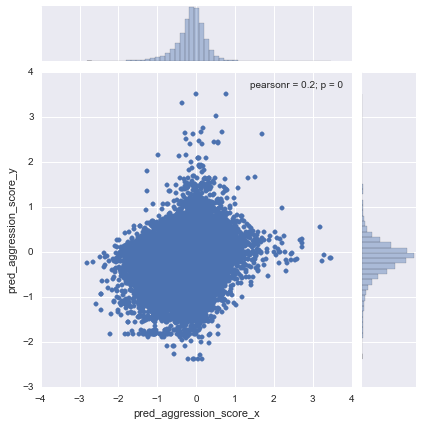

In [11]:
sns.jointplot(x = 'pred_aggression_score_x', y = 'pred_aggression_score_y', data = d_temp)

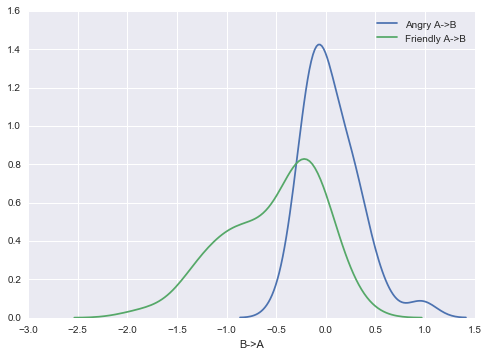

In [13]:
sns.distplot(d_temp.query('pred_aggression_score_x > 2')['pred_aggression_score_y'], hist=False, label = 'Angry A->B')
sns.distplot(d_temp.query('pred_aggression_score_x < -2')['pred_aggression_score_y'], hist=False, label = 'Friendly A->B')
#sns.distplot(d_temp.query('pred_aggression_score_x > - 0.5 and pred_aggression_score_x <  0.5')['pred_aggression_score_y'], hist=False, label = 'Neutral A->B')
plt.xlabel('B->A')

#  How does tone depend on the frequency of commenting?

In [94]:
tresholds = [int(np.percentile(df_no_admin_2015['user_text'].value_counts(), p)) for p in range(0, 101,2 )]
tresholds = sorted(set(tresholds))
tresholds

In [97]:
bins = []
for i in range(len(tresholds)-1):
    label = '%d-%d' % (tresholds[i], tresholds[i+1]-1)
    rnge = range(tresholds[i], tresholds[i+1])
    bins.append((label, rnge))
    
bins   

In [107]:
d_temp = df_no_admin_2015.groupby('user_text')['pred_aggression_score'].agg( {'aggressiveness': np.mean, 'count': len})

def map_count(x):
    for label, rnge in bins:
        if x in rnge:
            return label
        
d_temp['# comment range'] =   d_temp['count'].apply(map_count)

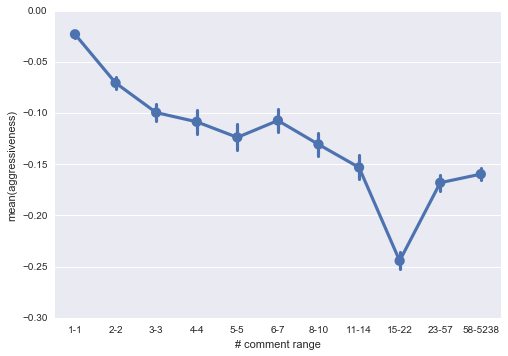

In [108]:
o = [e[0] for e in bins]
sns.pointplot(x='# comment range', y= 'aggressiveness', data= d_temp, order = o)